In [1]:
from lib.utils import * # Import custom utility functions
import gymnasium as gym
import pogema
from pogema import GridConfig
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

GRID_LEN = 18
env_path = 'saved/diff_env.yml'
ENV_NAME = 'ENV_D'
SAVE_PARAMS_PATH = 'saved/tuned_params.yml'
SAVE_METRICS_PATH = 'saved/evaluation_metrics.yml'
ENV_PARAMS = get_model_log(ENV_NAME, env_path) #load env params 
MODEL_NAME = 'PPO_D'
MAX_TRIALS = 1000                                   # For evaluation_metrics()
MAX_EPISODE_STEPS = ENV_PARAMS['MAX_EPISODE_STEPS']

def custom_step(self, action: list):
        assert len(action) == self.grid_config.num_agents
        rewards = []
        terminated = []

        self.move_agents(action)
        self.update_was_on_goal()

        for agent_idx in range(self.grid_config.num_agents):

            c_x, c_y = self.grid.positions_xy[agent_idx]
            f_x, f_y = self.grid.finishes_xy[agent_idx]

            reward = -( (abs(c_x - f_x) + abs(c_y - f_y)) / (2 * GRID_LEN) )
            #print(f"[CURR] {c_x}, {c_y} [FINISH] {f_x}, {f_y} [DIST] {d} [REWARD] {reward}")

            on_goal = self.grid.on_goal(agent_idx)
            if on_goal and self.grid.is_active[agent_idx]:
                print("FINISH", reward)
                rewards.append(100)
            else:
                rewards.append(reward)
            terminated.append(on_goal)

        for agent_idx in range(self.grid_config.num_agents):
            if self.grid.on_goal(agent_idx):
                self.grid.hide_agent(agent_idx)
                self.grid.is_active[agent_idx] = False

        infos = self._get_infos()

        observations = self._obs()
        truncated = [False] * self.grid_config.num_agents
        return observations, rewards, terminated, truncated, infos

pogema.envs.Pogema.step = custom_step

grid_config = GridConfig(
    size=ENV_PARAMS['GRID_SIZE'],                                 # size of the grid map 8 = (8x8)
    density=ENV_PARAMS['DENSITY'],                                # obstacle density
    num_agents=1,                                   # number of agents
    obs_radius=ENV_PARAMS['OBS_RADIUS'],                          # defines field of view
    max_episode_steps=ENV_PARAMS['MAX_EPISODE_STEPS'],            # time horizon
    seed=None                                       # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [3]:
model_params = get_model_log(MODEL_NAME, SAVE_PARAMS_PATH)
# add additional params for logging of agent training
extra_params = {
    "env":env,
    "tensorboard_log":"./tensorboard"
}
model_params.update(extra_params)
model = load_model_params(PPO, model_params)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
# Evaluate untrained agent using env
val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_ppo_model = PPO(
    "MlpPolicy",
    val_env,
    verbose=1
)

mean_reward, std_reward = evaluate_policy(
    val_ppo_model,
    val_ppo_model.get_env(),
    deterministic=True,
    n_eval_episodes=MAX_EPISODE_STEPS,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
FINISH -0.0
FINISH -0.0
mean_reward: -4.27 +/- 19.00


In [5]:
# Train agent and save it
model.learn(total_timesteps=int(3.0e5), tb_log_name=f"dqn_baseline_{MODEL_NAME}")
model.save(f"saved/dqn_baseline_{MODEL_NAME}")

Logging to ./tensorboard/dqn_baseline_PPO_D_1
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44.3     |
|    ep_rew_mean     | 37.2     |
| time/              |          |
|    fps             | 1705     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 47.2        |
|    ep_rew_mean          | 32.9        |
| time/                   |           

### Load trained agent and evaluate it

In [6]:
model = PPO.load(f"saved/dqn_baseline_{MODEL_NAME}")

env.reset()
mean_reward, std_reward = evaluate_policy(model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
mean_reward:66.93 +/- 50.18


/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [7]:
from IPython.display import SVG, display

metrics = evaluate_metrics(model, env, MODEL_NAME, num_episodes=MAX_EPISODE_STEPS, num_trials=MAX_TRIALS, verbose=False, save_animation=True)
save_metrics(metrics, MODEL_NAME, SAVE_METRICS_PATH)
print(f"Agent Success Rate: {metrics['success_rate'] * 100:.2f}%")
print(f"Steps to termination : {metrics['step_array']}")
print(f"Average steps to termination : {metrics['ave_steps']}")
print(f"Reward for each successful trial: {metrics['reward_array']}")
print(f"Reward for each trial: {metrics['all_reward_array']}")

FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINI

### Load Animation

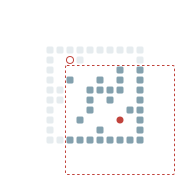

In [8]:
display(SVG(f'renders/render_{MODEL_NAME}.svg'))

In [9]:
# %tensorboard --logdir tensorboard/dqn_baseline_DQN_D_1
!python3 /Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/tensorboard/main.py --logdir tensorboard/dqn_baseline_PPO_D_1

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C
